# 环境变量

In [2]:
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'
distilled_log_dir=output_dir+'distilled_log/'
chapter_summary_dir=output_dir+'chapter_summary/'
merged_log_path=output_dir+'merged_log.json'
rename_map_path=output_dir+'rename_map.json'



bg_hint_len=500
retrospect_len=100
summary_chunk_len=500 # shouldn't be too large. because chatgpt's summary is very short. need to fine-tune this number
summary_chunk_overlap=0
final_summary_chunk_len=2000

import os, json
rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}

if not os.path.exists(chapter_summary_dir):
    os.makedirs(chapter_summary_dir)

# 加载llm

In [3]:
from my_llm import llm_chatgpt as llm
llm('你好')

c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


你好你好！有什么我可以帮助你的吗？


'你好！有什么我可以帮助你的吗？'

# 加载FAISS背景知识索引

In [4]:
import importlib,my_faiss;importlib.reload(my_faiss)
from my_faiss import FAISS,embeddings,get_bg_hint
get_bg_hint.vector_store=FAISS.load_local(faiss_path, embeddings)

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


# 处理gpt返回的json

In [5]:
import json,random
from glob import glob
import os
from tqdm.auto import tqdm

chunks={}
for path in glob(os.path.join(distilled_log_dir,'RESPONSE*.json')):
    with open(path) as f:
        chunk=json.load(f)
        for item in chunk['content']:
            item['src_id']=chunk['id']
        chunks[chunk['id']]=chunk
print('load chunks:',len(chunks))

chunks=dict(sorted(chunks.items(), key=lambda item: item[0]))

all_content=[item for chunk in chunks.values() for item in chunk['content']]


# # separate info, act into individual items
def purge_content(all_content):
    for item in all_content:
        if 'info' in item:
            info_str=item['info']
            if 'expression' in item:
                info_str=item['expression']+' '+info_str
            if 'char' in item:
                info_str=item['char']+' '+info_str
            yield {'info':info_str,'src_id':item['src_id']}
        if 'char' in item:
            base_info={'char':item['char'],'src_id':item['src_id']}
            if 'expression' in item:
                base_info['expression']=item['expression']
            if 'act' in item:
                yield {**base_info,'act':item['act']}
            else:
                if 'think' in item:
                    base_info['think']=item['think']
                if 'say' in item:
                    base_info['say']=item['say']
                if 'think' in item or 'say' in item:
                    yield base_info

all_content=list(purge_content(all_content))

all_content[:10]

print('Total items:', len(all_content))

json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

load chunks: 561
Total items: 8626


### 统计角色出现的频率，统一名字中的同音字

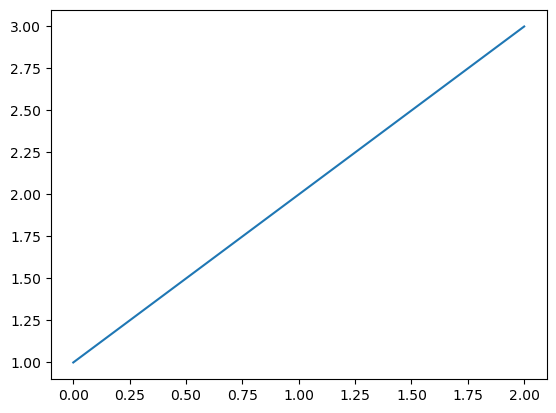

In [6]:
# run this block to avoid crash when loading chinese font in matplotlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.figure()
plt.plot([1,2,3])
plt.show()


load, update and save rename_map at path: ./output_zero/rename_map.json


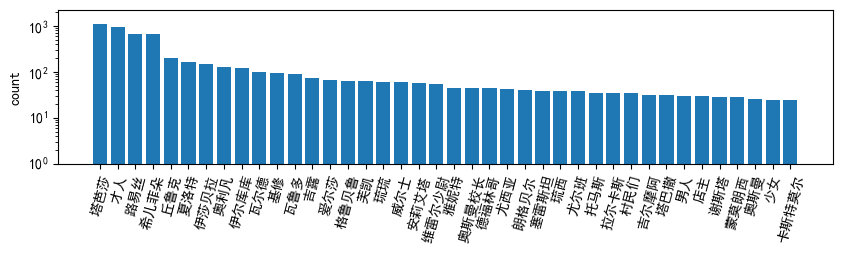

list of characters and their frequencies: {'塔芭莎': 1121, '才人': 972, '路易丝': 681, '希儿菲朵': 663, '丘鲁克': 201, '夏洛特': 168, '伊莎贝拉': 152, '奥利凡': 128, '伊尔库库': 124, '瓦尔德': 98, '基修': 95, '瓦鲁多': 92, '吉露': 72, '爱尔莎': 67, '格鲁贝鲁': 65, '芙凯': 64, '琉琉': 60, '威尔士': 59, '安莉艾塔': 58, '维雷尔少尉': 54, '雅妮特': 45, '奥斯曼校长': 45, '德福林哥': 44, '尤西亚': 42, '朗格贝尔': 40, '塞雷斯坦': 39, '琉西': 39, '尤尔班': 38, '托马斯': 35, '拉尔卡斯': 35, '村民们': 34, '吉尔摩阿': 32, '塔巴撒': 31, '男人': 30, '店主': 30, '谢斯塔': 29, '蒙莫朗西': 29, '奥斯曼': 26, '少女': 25, '卡斯特莫尔': 25, '谢弗勒兹': 25, '萨姆': 23, '男子': 21, '琉吉尼恩子爵': 21, '罗德巴尔德男爵夫人': 21, '老婆婆': 19, '托马': 19, '露易丝': 19, '村长': 18, '地下水': 18, '艾伯特': 18, '船长': 18, '爱夏': 17, '琪尔可': 17, '库尔凯': 17, '米诺塔洛斯': 17, '雌火龙': 16, '侍女': 15, '亚尔托瓦伯': 15, '学生们': 15, '魔法师': 15, '哥布灵萨满': 15, '军官': 14, '女头目': 14, '库拉威尔卿': 13, '马扎利意尼': 13, '奥尔良公': 12, '朗格贝尔小姐': 12, '安莉艾塔公主': 12, '安丽埃塔': 12, '母亲': 11, '尼娜': 11, '弗雷姆': 11, '小明': 11, '奥斯曼先生': 11, '德鲁福林哥': 11, '瓦鲁多子爵': 11, '阿利克山大': 10, '叽叽的父亲': 10, '奥斯曼氏': 10, '马鲁托': 10, '盖托': 10, '魔杖': 9, '

In [7]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']


rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}
rename_map_added={'塔巴萨':'塔芭莎','塔巴莎':'塔芭莎','雪丝塔':'谢斯塔','摩莫朗希':'蒙莫朗西','夏尔洛特':'夏洛特','希尔菲德':'希儿菲朵','西布鲁兹':'谢弗勒兹','谢丝塔':'谢斯塔'}
rename_map.update(rename_map_added)
json.dump(rename_map, open(rename_map_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('load, update and save rename_map at path:', rename_map_path)

# we use the original name in history text, but the new name for labeling

char_freq={}
for item in all_content:
    if 'char' in item:
        char=rename_map.get(item['char'], item['char'])
        if char not in char_freq:
            char_freq[char]=0
        char_freq[char]+=1
char_freq={k: v for k, v in sorted(char_freq.items(), key=lambda item: item[1], reverse=True)}
selected_char=list(sorted(char_freq.keys(), key=lambda x: char_freq[x], reverse=True)[:9999])

def list_char_items(content, char):
    for item in content:
        if item.get('char', None) == char:
            print(item)


plt.figure(figsize=(10, 2))
plt.bar(list(char_freq.keys())[:40], list(char_freq.values())[:40])
plt.xticks(rotation=75)
plt.ylabel('count')
plt.yscale('log')
plt.ylim(1,np.max(list(char_freq.values())[:20])*2)
plt.show()

print('list of characters and their frequencies:',char_freq)
print('rename_map:', rename_map)
print('selected_char:', selected_char)

# revising character name typo

def revise_name(obj):
    if isinstance(obj,str):
        for from_name,to_name in rename_map.items():
            obj=obj.replace(from_name,to_name)
        return obj,True
    else:
        return obj,False

def revise_json_object_recursive(obj,revise_func):
    obj,terminate=revise_func(obj)
    if not terminate:
        if isinstance(obj,dict):
            for key,value in obj.items():
                obj[key]=revise_json_object_recursive(value,revise_func)
        if isinstance(obj,list):
            for i in range(len(obj)):
                obj[i]=revise_json_object_recursive(obj[i],revise_func)
    return obj

all_content=revise_json_object_recursive(all_content,revise_func=revise_name)
chunks=revise_json_object_recursive(chunks,revise_func=revise_name)
print('revise name done (not saved yet)')

json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('save merged_log_path:', merged_log_path)

# 将chunk合并成章节，并进行总结

In [11]:
import glob

chapters={}
def reload_chapters():
    global chapters
    for chapter_summary_path in glob.glob(os.path.join(chapter_summary_dir, f'CHAPTER_.*.json')):
        chapter_summary = json.load(open(chapter_summary_path, 'r', encoding='utf-8'))
        iChapter = int(chapter_summary_path.split('.')[-2].split('_')[-1])
        chapters[iChapter]=chapter_summary
    print('reload',len(chapters),'chapters')

def save_chapter(iChapter,chapter):
    chapters[iChapter]=chapter
    json.dump(chapter, open(os.path.join(chapter_summary_dir, f'CHAPTER_{iChapter}.json'), 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
    print('save chapter',iChapter,'to',os.path.join(chapter_summary_dir, f'CHAPTER_{iChapter}.json'))

reload_chapters()

reload 0 chapters


In [15]:

for iChunk,chunk in tqdm(sorted(chunks.items())):
    chapter=chapters.get(int(chunk['chapter_id']), {}) 
    chapter['chapter_id']=chunk['chapter_id']
    chapter['title']=chunk['title']
    chapter['chunk_ids']=chapter.get('chunk_ids', [])+[chunk['id']]
    chapter['chunk_summaries']=chapter.get('chunk_summaries', [])+[chunk['summary']]

for iChapter,chapter in tqdm(chapters.items()):
    save_chapter(int(iChapter),chapter)

# json.dump(chapters, open(chapter_summary_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
# print('chapter summary saved to', chapter_summary_path)


  0%|          | 0/561 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

save chapter 0 to ./output_zero/chapter_summary/CHAPTER_0.json
save chapter 1 to ./output_zero/chapter_summary/CHAPTER_1.json
save chapter 2 to ./output_zero/chapter_summary/CHAPTER_2.json
save chapter 3 to ./output_zero/chapter_summary/CHAPTER_3.json
save chapter 4 to ./output_zero/chapter_summary/CHAPTER_4.json
save chapter 5 to ./output_zero/chapter_summary/CHAPTER_5.json
save chapter 6 to ./output_zero/chapter_summary/CHAPTER_6.json
save chapter 7 to ./output_zero/chapter_summary/CHAPTER_7.json
save chapter 8 to ./output_zero/chapter_summary/CHAPTER_8.json
save chapter 9 to ./output_zero/chapter_summary/CHAPTER_9.json
save chapter 10 to ./output_zero/chapter_summary/CHAPTER_10.json
save chapter 11 to ./output_zero/chapter_summary/CHAPTER_11.json
save chapter 12 to ./output_zero/chapter_summary/CHAPTER_12.json
save chapter 13 to ./output_zero/chapter_summary/CHAPTER_13.json
save chapter 14 to ./output_zero/chapter_summary/CHAPTER_14.json
save chapter 15 to ./output_zero/chapter_summ

### 将chunk的summary和bg_hint合并，作为chapter的summary

In [16]:
from langchain.chains.base import Chain
import json
import re
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

class FurtherSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    refine_bg_hint:bool=True
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
请去除下面情节梗概中重复的部分，请尽量不要丢掉信息。不要加入额外的推测，请忠实于原著。不要加入没有意思的套话。
{text}
精简后的情节梗概：'''
    def _call(self,inputs:dict)->dict:
        print('requesting summary')
        bghint_input=inputs.get('summary',inputs['text'])
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs.get('retrospect','(无)')[-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        if self.refine_bg_hint and 'summary' not in inputs:
            print('refine the summary by using the bg hint genereated by the current summary')
            return self._call({**inputs,'summary':response})
        else:
            return {'summary':response}
    

class FinalSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    refine_bg_hint:bool=False
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
请非常简要地概括下面的故事，字数限制在五十字以内，抓住重点，抓住关键的情节走向和可能对后文产生影响的重大细节。不要加入额外的推测，请忠实于原著。不要加入没有意思的套话。
{text}
精简后的情节梗概：'''
    def _call(self,inputs:dict)->dict:
        print('requesting summary')
        bghint_input=inputs.get('summary',inputs['text'])
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs.get('retrospect','(无)')[-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        if self.refine_bg_hint and 'summary' not in inputs:
            print('refine the summary by using the bg hint genereated by the current summary')
            return self._call({**inputs,'summary':response})
        else:
            return {'summary':response}


further_summary_story_chain=FurtherSummaryStoryChain(llm=llm,get_bg_hint=get_bg_hint,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len)
final_summary_story_chain=FinalSummaryStoryChain(llm=llm,get_bg_hint=get_bg_hint,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len) 
text_splitter=RecursiveCharacterTextSplitter(chunk_size=summary_chunk_len,chunk_overlap=summary_chunk_overlap)

def further_summary_story(summaries,retrospect=None,final_summary_chunk_len=250):
    all_summary_text='\n'.join([summary.replace('\n','') for summary in summaries])
    retrospect=retrospect or '（无）'
    if len(all_summary_text)<=final_summary_chunk_len:
        print('length of all summaries is less than final_summary_chunk_len, no further summarizing')
        final_summary=final_summary_story_chain({'text':all_summary_text,'retrospect':retrospect})['summary']
        if len(summaries)==1:
            return [final_summary]
        else:
            return [final_summary,['\n'.join(summaries)]]
    else:
        print('further summarizing story, num of summaries at current level:',len(summaries), 'total length:',sum([len(summary) for summary in summaries]))
        text_chunks=text_splitter.split_text(all_summary_text)
        chunk_summaries=[]
        chunk_retrospect=''
        for text_chunk in text_chunks:
            all_retrospect=(retrospect+'。'+chunk_retrospect).replace('\w','')
            chunk_summary=further_summary_story_chain({'text':text_chunk,'retrospect':all_retrospect})['summary']
            chunk_retrospect=chunk_summary
            chunk_summaries.append(chunk_summary)
        cascades=further_summary_story(chunk_summaries,retrospect,final_summary_chunk_len=final_summary_chunk_len)
        return cascades+[chunk_summaries]

# llm.show_query=llm.show_response=True

# summaries=chapters[22]['chunk_summaries']
# # summaries=chapters[21]['chunk_summaries']+chapters[22]['chunk_summaries']+chapters[23]['chunk_summaries']
# summary_cascades=further_summary_story(summaries,final_summary_chunk_len=final_summary_chunk_len)
# print('final summary:',summary_cascades[0])
# print('semifinal summary:',summary_cascades[1])
# print('summary cascade:',summary_cascades)

# llm.show_query=llm.show_response=False

In [17]:
from my_chains import Text2JsonChain



class ExtractStoryElementsChain(Text2JsonChain):
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    summary_len:int=100
    retrospect_len:int=100
    story_summary_chain:object=None
    prompt='''可能有关的背景信息：（不要加入到回复中）
{background}
【前情提要：{retrospect}】
【本段概要：{summary}】
对下文中的主要角色，分条提取角色动机motivation，遇到的主要阻碍obstacle，所做出的行为与决策action，以及和这一切有关的角色性格特征trait，和背景信息background。
只需要输出主要角色，按你认为的角色的重要性排序。
输出格式：{{
    "小明":{{
        "motivation":"上街买菜",
        "obstacle":"没钱",
        "action":"找人借钱",
        "trait":"小明很穷",
        "role":"小明在情节中扮演了购买者的角色",
        "background":"菜涨价了",
        "development":"小明决定以后不买菜了",
        "reflection":"反应了小明很可怜"
    }}
}}
确保json格式正确。
不加自己的推测想法，请忠实于原著，不要盲目正面。不要加入没有意思的套话。请修正可能被搞混淆的角色名字。
可能有关的背景信息：（不要加入到回复中）
文本：
{text}
json：'''
    @property
    def output_keys(self):
        return super().output_keys+['summary','background','retrospect']
    def _call(self,inputs:dict)->dict:
        summary=self.story_summary_chain({**inputs,'summary':inputs['text']})['summary'] if self.story_summary_chain is not None and 'summary' not in inputs else inputs.get('summary','（无）')
        bg_hint_input=summary if 'summary' in inputs else inputs['text']
        bg_hint=self.get_bg_hint(bg_hint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len) if self.get_bg_hint is not None else '（无）'
        retrospect=inputs.get('retrospect','（无）')

        inputs['summary']=summary.replace('\n','').strip()[:self.summary_len]
        inputs['background']=bg_hint.strip()[-self.bg_hint_len:]
        inputs['retrospect']=retrospect.replace('\n','').strip()[-self.retrospect_len:]

        print('requesting ExtractStoryElementsChain')
        outputs=super()._call(inputs)
        outputs['summary']=summary.replace('\n','')
        outputs['background']=bg_hint
        outputs['retrospect']=retrospect.replace('\n','')
        return outputs
    
extract_story_elements_chain=ExtractStoryElementsChain(llm=llm,get_bg_hint=get_bg_hint,story_summary_chain=further_summary_story_chain,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len)


# llm.show_query=llm.show_response=True
# story_elements=extract_story_elements_chain({'text':'\n'.join(summary_cascades[1]),'summary':summary_cascades[0]})
# llm.show_query=llm.show_response=False

In [19]:
reload_chapters()
llm.show_query=llm.show_response=False
for iChapter,chapter in tqdm(chapters.items()):
    print('processing chapter',iChapter,chapter['title'])
    retrospect=chapters[iChapter-1]['summary'] if iChapter-1 in chapters and 'summary' in chapters[iChapter-1] else '（无）'
    if 'summary_cascades' not in chapter:
        chapter['summary_cascades']=further_summary_story(chapter['chunk_summaries'],final_summary_chunk_len=final_summary_chunk_len)
    chapter['summary']=chapter['summary_cascades'][0]
    save_chapter(chapter)
    if 'story_elements' not in chapter:
        response=extract_story_elements_chain({'text':'\n'.join(chapter['summary_cascades'][1]),'summary':chapter['summary'],'retrospect':retrospect})
        if response['content'] is not None:
            chapter['story_elements']=response['content']
        else:
            print('story elements extraction failed')
            print(response['error'])
            chapter['story_elements_failed']=response['response']
    save_chapter(chapter)

reload 39 chapters


  0%|          | 0/39 [00:00<?, ?it/s]

processing chapter 0 第零卷 塔芭莎的冒险 塔芭莎与翼龙人
further summarizing story, num of summaries at current level: 108 total length: 12076
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary
requesting summary
refine the summary by using the bg hint genereated by the current summary
requesting summary


# Trash code after here

In [ ]:
assert False

In [ ]:
class FinalSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text','retrospect']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
问：下面是一个完整的小说章节中不同段落的分段梗概，请用连贯的语言详述一下本小说章节。不要加入额外的推测，请忠实于原著，不要加入没有意思的概概而谈的套话。
{text}
答：'''
    def _call(self,inputs:dict)->dict:
        bghint_input=inputs['text']
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs['retrospect'][-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        print('requesting summary')
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        return {'summary':response}